In [1]:
# Import libraries
import os
import sys
sys.path.append('../')
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=6
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from econml.sklearn_extensions.linear_model import WeightedLassoCV
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.metrics as sme
import sklearn.feature_selection as skf
import sklearn.ensemble as ske
import sklearn.utils as sku
import sklearn.decomposition as skd
import sklearn.neural_network as skn
from celer import GroupLassoCV
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
from scipy.spatial import cKDTree
import nibabel as nib
import os
import pickle
from torch import nn
from sklearn.exceptions import ConvergenceWarning
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
# Maybe y should also be scaled? 
# Perhaps a transform would be more effective, or scaling implemented with consistent cross-validation
# Different scaling methods? 
#     This seems most important for noise-sensitive models like LARS. All other use StandardScaler()
# Transformers?
# Model-specific scaling methods?
#     Yes, see above
# Common cross-validation function ✓
#     Use built-in functions wherever possible and `utils.gridsearch_pickparams()` elsewhere
# Quantile loss
# RANSAC
# Data augmentation? (Mixup)
# Data generation? (SMOGN)
# Combine CHH dataset ✓
# Implement CV and test ✓
# Print selected features ✓
# Make magnitude templates
# Sample weights ✓
# Look at segmentations by error ✓ (Appears to have most difference in red nucleus, which includes surrounding (white?) matter for underperforming cases)
# Extract features from current (1:6) eroded ROIs
# Extract features from all ROIs
# Plot segmentation variance against error for each case across all ROIs ✓
# Why does excluding the subthalamic nucleus increase the correlation (r=0.5 -> r=0.6)?
# Best performance with all ROIs: cvn=6, k=1800
# Best performance with ROIs 0:4, excluding STN: cvn=6, k=1800
# Should the pre-operative UPDRS be appended once or to each ROI? ✓
# Plot histogram of features for successful and unsuccessful predictions

In [4]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528_wldd.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','pre op levadopa equivalent dose (mg)','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off,ledd = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo',
                                                          'pre op levadopa equivalent dose (mg)')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi_o/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X_o/',npy_dir+'R_o/',npy_dir+'K_o/',n_rois,1595,all_rois)

ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,0:4,:]
K_all_c = K_all[c_cases_idx,0:4,:]
R_all_c = R_all[c_cases_idx,0:4,:]
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
subsc = subs[s_cases_idx]
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
ledd = ledd[s_cases_idx]
per_change = post_imp
# Reshape keys and ROIs
if all_rois == True:
    K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
    K_all_cu[:,:,:-1] = K_all_c
    K_all_cu[:,:,-1] = 'pre_updrs'
    K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
else:
    K = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
    K = np.append(K,['pre_updrs'],0)
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))


       Unnamed: 0                PRE-OP           Unnamed: 2  \
0      CORNELL ID  Apathy Off (pre-dbs)  Apathy ON (pre-dbs)   
1              67                    na                   13   
2   only Ct data                     na                   na   
3              74                    na                   na   
4              84                    na                   22   
..            ...                   ...                  ...   
87             52                   NaN                  NaN   
88             53                   NaN                  NaN   
89             54                   NaN                  NaN   
90             55                   NaN                  NaN   
91             56                   NaN                  NaN   

             Unnamed: 3          Unnamed: 4    Unnamed: 5  \
0   OFF (pre-dbs updrs)  ON (pre-dbs updrs)  mri (pre-op)   
1                    60                  41      3/9/2020   
2                    43                  12     

In [5]:
scoring = 'r2'
results_bls = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_gls = np.zeros_like(per_change)
gerror = np.zeros_like(per_change)
r = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
err_var = np.zeros_like(per_change)
alphas = np.logspace(-4,4,100)
Ks = []
Kstg = []
w = []
wg = []
pcases = []
pscores = []
s = []

In [16]:
Js = []
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = np.round(per_change[train_index],1)
    y_test = np.round(per_change[test_index],1)
    y_cat = y_train > 0.3
   
    
    # Cross validation
    cvn = 6
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,test_index,pre_updrs_off,ledd,False,False,False)
    lasso = slm.LassoLarsCV(max_iter=1000,cv=cvn,normalize=False,eps=0.1,n_jobs=1)

    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
      # Feature selection
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      sel = skf.SelectKBest(skf.r_regression,k='all')
      X0_sst = sel.fit_transform(X0_ss0,y_train)
      X_test_sst = sel.transform(X_test_ss0)
      gel = skf.RFECV(lasso,verbose=0,cv=cvn,step=100,n_jobs=1)
      X0_ss = gel.fit_transform(X0_sst,y_train)
      
      X_test_ss = gel.transform(X_test_sst)
     #Ks.append(sel.transform(K.reshape(1, -1)))



    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      # lasso = slm.LassoLarsCV(max_iter=1000,cv=cvn,n_jobs=1,normalize=False,eps=0.1)
      lr = slm.LassoLarsCV(normalize=False)
      est_ls = lr.fit(X0_ss,y_train)
    # Reconstruct nearest neighbor
    results_ls[j] = est_ls.predict(X_test_ss)

    print('Lasso predicts',str(np.round(results_ls[j],2)),
              'for case',str(subsc[j]),'with',str(np.round(per_change[j],2)),
              'with regularization',str(est_ls.alpha_))

  


Lasso predicts 0.46 for case 67.0 with 0.48 with regularization 0.017996447439202295
Lasso predicts 0.56 for case 75.0 with 0.97 with regularization 0.0
Lasso predicts 0.63 for case 68.0 with 0.75 with regularization 0.1377638977246613
Lasso predicts 0.63 for case 79.0 with 0.66 with regularization 0.1336681546264803
Lasso predicts 0.68 for case 59.0 with 0.74 with regularization 0.0
Lasso predicts 0.65 for case 85.0 with 0.15 with regularization 0.13178603244818246
Lasso predicts 0.63 for case 63.0 with 0.85 with regularization 0.1277054773980299
Lasso predicts 0.64 for case 66.0 with 0.53 with regularization 0.13284615503501995
Lasso predicts 0.64 for case 86.0 with 0.5 with regularization 0.13236150772441568
Lasso predicts 0.64 for case 69.0 with 0.49 with regularization 0.13245769919807057
Lasso predicts 0.64 for case 72.0 with 0.26 with regularization 0.09922898867870199
Lasso predicts 0.63 for case 80.0 with 0.52 with regularization 0.0
Lasso predicts 0.64 for case 81.0 with 0.19

ValueError: shapes (31,31) and (30,) not aligned: 31 (dim 1) != 30 (dim 0)

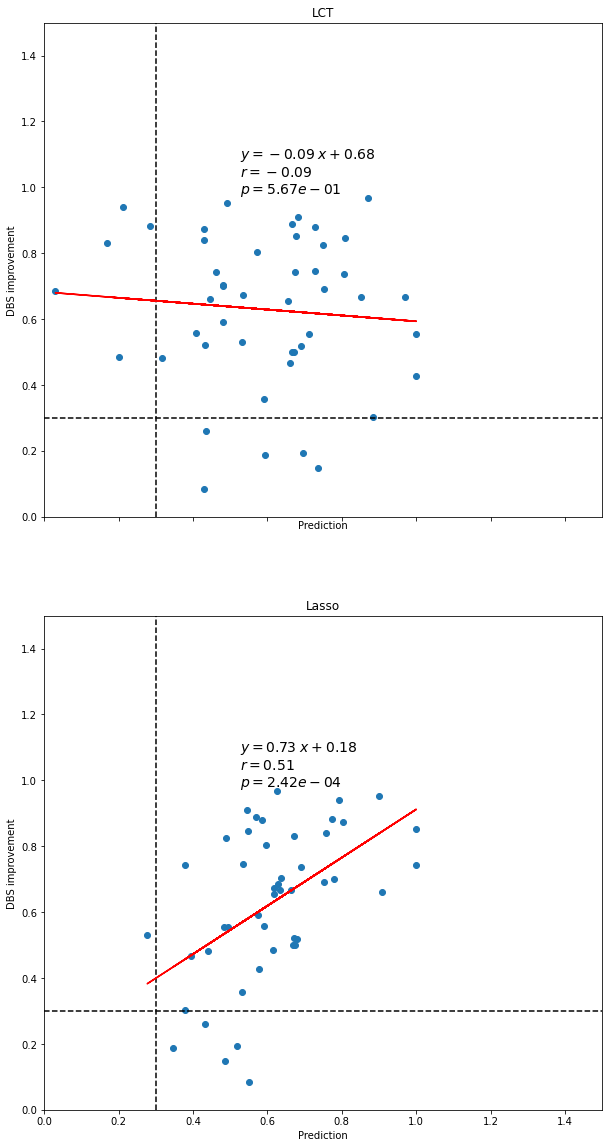

In [ ]:
results_ls[results_ls>1] = 1
util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(20,10))
plt.ylim([0,1.5])
plt.xlim([0,1.5])
plt.style.use('default')